<a href="https://colab.research.google.com/github/rolnz/MVA_Bayes_ML/blob/main/Bayes_ML_EM_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Augmentation for Support Vector Machines**

  In this small notebook, we want to test an SVM algorithm with Data augmentation, as described in the paper Data Augmentation for Support Vector Machines, written by N.polson and S. L. Scott in 2011. 
A source is  https://projecteuclid.org/journals/bayesian-analysis/volume-6/issue-1/Data-augmentation-for-support-vector-machines/10.1214/11-BA601.full. 
At first we will display a point estimation by EM and related algorithm, then we will use MCMC techniques for SVM.

Here we import some packages for the project and some packages for datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from scipy.integrate import quad    
from scipy.special import gamma
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from scipy.linalg import sqrtm


Now we can load some datasets for SVM : an example is breast cancer dataset (Source : https://scikit-learn.org/stable/datasets/toy_dataset.html) where we want to predict the class of the cancer : malignant (1) or benign (0).
We normalisee the dataset with the z-core

In [2]:
#dataset with two classes for breast cancer
dataset_cancer = datasets.load_breast_cancer()
features_names = dataset_cancer.feature_names[:6]
non_normalized_dataframe_cancer = pd.DataFrame(dataset_cancer.data[:, [i for i in range(6)]], 
                                columns = features_names)
dataframe_cancer = pd.DataFrame(StandardScaler().fit_transform(non_normalized_dataframe_cancer), 
                      columns = features_names)
dataframe_cancer['target'] = pd.Series(dataset_cancer.target)


We convert the dataset into a numpy dataset.

In [3]:
#We tranform the dataset into a numpy array.
X0 = dataframe_cancer[features_names].to_numpy()

#We add column for constant term.
n_lines0, n_columns0 = np.shape(X0)
X = np.append(X0, [[1] for i in range(n_lines0)], axis = 1) 

#y takes from -1,1 for the algorithm.
n_lines, n_colums = np.shape(X)
y = 2*dataframe_cancer['target'].to_numpy() - np.ones(n_lines) 


Now, separate the dataset into a train set (75%) and a test set (25%)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=42)


**Part I : EM and ECME algorithm**

We write some useful functions for our algorithm.
All the differents formulas are noted in the paper.


In [5]:
def parameters(x, y):
    n, k = np.shape(x)
    sigma = np.array([np.std(x[:][j]) for j in range(k)])
    big_sigma = np.diag(np.square(sigma))
    bold_X = np.array([y[i]*x[i] for i in range(n)])
    return (sigma,  big_sigma, bold_X)

def E_Step(nu, sigma, x, y, beta):
    n, k = np.shape(x)
    lambda_g = np.array([np.abs(1/(1-(y[i]*np.dot(x[i].T, beta)))) 
              for i in range(n)])
    big_lambda_g = np.diag(lambda_g)
    big_omega_g = np.diag([nu * sigma[j] * np.abs(1/beta[j]) for j in range(k)])
    return (lambda_g, big_lambda_g, big_omega_g)

def CVM_Step(big_omega_g, lambda_g, big_lambda_g, big_sigma, bold_X, x, y, nu):
    n, k = np.shape(x)
    beta = np.dot(np.linalg.inv((nu**(-2) * np.dot(np.linalg.inv(big_sigma), 
          big_omega_g)) + np.dot(bold_X.T, np.dot(big_lambda_g, bold_X))),
          np.dot(bold_X.T, np.ones(n)+ lambda_g))
    return beta

def CME_Step(sigma, alpha, beta, x, y, b_nu, a_nu, nu):
    n, k = np.shape(x)
    numerator = b_nu + np.sum([(np.abs(beta[j]/sigma[j]))**alpha for j in range(k)])
    denominator = k/alpha + a_nu - 1
    return (numerator/denominator)**(-1/alpha)


Now we build ours algorithms of EM and ECME.

In [6]:
def EM_SVM_algorithm(x, y, nu = 1, epsilon = 1, n_max_step = 100):
    n, k = np.shape(x)
    beta = np.ones(k)
    previous_beta = np.array([np.inf for i in range (k)])
    (sigma,  big_sigma, X) = parameters(x, y)
    step = 0
    while (np.linalg.norm(beta-previous_beta) > epsilon) and (step < n_max_step):
        previous_beta = beta
        lambda_g, big_lambda_g, big_omega_g = E_Step(nu, sigma, x, y, beta)
        beta = CVM_Step(big_omega_g, lambda_g, big_lambda_g, big_sigma, X, x, y, nu)
        step += 1
    return (beta)

def ECME_SVM_algorithm(x, y, nu = 1, epsilon = 1, alpha = 1, b_nu = 1, 
                       a_nu = 1, n_max_step = 100) :
    n, k = np.shape(x)
    beta = np.ones(k)
    previous_beta = np.array([np.inf for i in range (k)])
    previous_nu = np.inf
    (sigma,  big_sigma, X) = parameters(x, y)
    step = 0
    while (max(np.linalg.norm(beta-previous_beta),np.linalg.norm(nu-previous_nu)) 
         > epsilon) and (step < n_max_step):
        previous_beta = beta
        previous_nu = nu
        lambda_g, big_lambda_g, omega_g = E_Step(nu, sigma, x, y, beta)
        beta = CVM_Step(omega_g, lambda_g, big_lambda_g, big_sigma, X, x, y, nu)
        nu = CME_Step(sigma, alpha, beta, x, y, b_nu, a_nu, nu)
        step += 1
    return (beta)


We build a small function to get some machine learning results.


In [7]:
def scores(predict_data, test_data):
    n = len(test_data)
    n_real_positive = (test_data > 0).sum() # True positive & false negative
    n_predicted_positive = (predict_data > 0).sum() #True positive & false positive
    n_true_positive = 0 #True positive 
    for i in range(n):
        if (predict_data[i] == 1) and  (test_data[i] == 1) :
            n_true_positive +=1
    precision = n_true_positive/n_predicted_positive * 100
    recall = n_true_positive/n_real_positive * 100
    f1_score = (2*recall*precision)/(recall + precision)
    return (precision, recall, f1_score)


Now we can test our algothms and compared them to a standardised python method. In this first test $\nu = 1$ for EM.

precion_EM : 97.6470588235294 , recall_EM : 93.25842696629213 , f1_score_EM : 95.4022988505747
precion_ECME : 97.6470588235294 , recall_ECME : 93.25842696629213 , f1_score_ECME : 95.4022988505747
precision_sklearn : 95.55555555555556 , recall_sklearn : 96.62921348314607 , f1_score_sklearn : 96.08938547486034


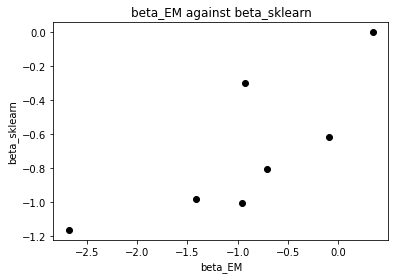

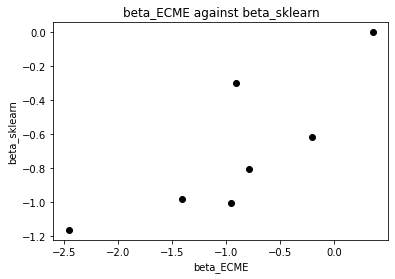

In [8]:
def EM_ECME_sklearn_computation(X_train, y_train, X_test, y_test, alpha = 1, 
                                nu = 1, epsilon = 1, n_max_step = 100, 
                                a_nu = 1, b_nu = 1):
        #Some other variables initialized
        n_row, n_column = np.shape(X_train)
        beta = np.ones(n_column)

        #Estimations of betas with the algorithms
        beta_EM = EM_SVM_algorithm(X_train, y_train)
        beta_ECME = ECME_SVM_algorithm(X_train, y_train)

        #Test on test data 

        y_pred_EM = np.sign(np.dot(beta_EM,X_test.T))
        y_pred_ECME = np.sign(np.dot(beta_ECME,X_test.T))
        precion_EM, recall_EM, f1_score_EM = scores(y_pred_EM, y_test)
        precion_ECME, recall_ECME, f1_score_ECME = scores(y_pred_ECME, y_test)

        print('precion_EM :', precion_EM, ', recall_EM :',
              recall_EM, ', f1_score_EM :',f1_score_EM)
        print('precion_ECME :', precion_ECME, ', recall_ECME :',
              recall_ECME,', f1_score_ECME :', f1_score_ECME)

        #Classic SVM 
        svm_model =  SVC(kernel = 'linear')
        svm_model.fit(X_train, y_train)
        beta_sklearn = svm_model.coef_[0]
        y_pred_sklearn = svm_model.predict(X_test)
        precion_sklearn, recall_sklearn, f1_score_sklearn = scores(y_pred_sklearn, 
                                                                  y_test)
        print('precision_sklearn :', precion_sklearn, ', recall_sklearn :',
              recall_sklearn, ', f1_score_sklearn :', f1_score_sklearn)
        
        #EM algorithm
        plt.scatter(beta_EM, beta_sklearn, color = 'black')
        plt.xlabel('beta_EM')
        plt.ylabel('beta_sklearn')
        plt.title('beta_EM against beta_sklearn')
        plt.show()
        print()

        #ECME algorithm
        plt.scatter(beta_ECME, beta_sklearn, color = 'black')
        plt.xlabel('beta_ECME')
        plt.ylabel('beta_sklearn')
        plt.title('beta_ECME against beta_sklearn')
        plt.show()
        
        return beta_EM, beta_ECME, beta_sklearn

#The different values of beta 
beta_EM, beta_ECME, beta_sklearn = EM_ECME_sklearn_computation(X_train, y_train,
                                   X_test, y_test, alpha = 1, nu = 1)




We test that for differents value of nu for EM and plot the results.

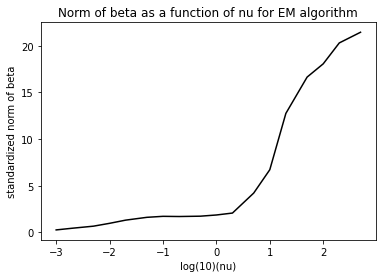

In [9]:
nus_default = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1,
                        2, 5, 10, 20, 50, 100, 200, 500])

def EM_beta_norm(X_train, y_train, nus = nus_default):
    n, k = np.shape(X_train)
    beta = np.ones(k)
    sigma = np.array([np.std(X_train[:][j]) for j in range(k)])
    normalised_norm = []
    for nu in nus:
        result_beta = EM_SVM_algorithm(X_train, y_train, nu = nu)
        normalised_beta = [result_beta[j] * sigma[j] for j in range(k)]
        normalised_norm.append(np.linalg.norm(normalised_beta))
    plt.plot(np.log10(nus), normalised_norm, color = 'black')
    plt.xlabel('log(10)(nu)')
    plt.ylabel('standardized norm of beta')
    plt.title('Norm of beta as a function of nu for EM algorithm')
    plt.show()

EM_beta_norm(X_train, y_train)


**Part II: MCMC-SVM algorithm and spike and slab**

Now we build an algorithm for MCMC-SVM algorithm.
At first we build the four step functions.

In [10]:
#Step 1

def b_and_B_values(nu, big_sigma, big_omega_g, lambda_g, bold_X):
    n,m = np.shape(bold_X)
    big_lambda_g = np.diag(lambda_g)
    B = np.linalg.inv((nu**(-2) * np.dot(np.linalg.inv(big_sigma), 
          big_omega_g)) + np.dot(bold_X.T, np.dot(big_lambda_g, bold_X)))
    b = np.dot(B, np.dot(bold_X.T, np.ones(n) + lambda_g))
    return(b, B)

def step_one_mcmc_svm(nu, big_sigma, big_omega_g, lambda_g, bold_X):
    
    b, B = b_and_B_values(nu, big_sigma, big_omega_g, lambda_g, bold_X)
    return np.random.multivariate_normal(b , B)

#Step 2
def step_two_mcmc_svm(beta, x, y):
    n, k = np.shape(x)
    lambda_g = np.array([np.random.wald(np.abs(1-y[i]*np.dot(x[i],beta)),1) 
            for i in range(n)])
    big_lambda_g = np.diag(lambda_g)
    return (lambda_g, big_lambda_g)

#Step 3
def step_three_mcmc_svm(sigma, beta, nu, x, y):
    n, k = np.shape(x)
    omega_g = []
    for i in range(k):
        if beta[i] != 0:
            omega_g.append(np.random.wald(np.abs(nu*sigma[i]*(beta[i]**(-1))),1)) 
        else:
            omega_g.append(0)
    big_omega_g = np.diag(omega_g)
    return (omega_g, big_omega_g)
    

#Step 4
def step_four_mcmc_svm(a_nu, b_nu, beta):
    k = len(beta)
    return 1/np.random.gamma(a_nu + k, b_nu + np.linalg.norm(beta, ord = 1))
    

Now we compute the MCMC-SVM algorithm with all the differents step functions written above

In [11]:
def MCMC_SVM_algorithm(x, y, nu = 1, a_nu = 1, b_nu = 1, epsilon = 1, 
                       n_max_step = 100):
    n, k = np.shape(x)
    previous_beta = np.array([np.inf for i in range (k)])
    beta = np.ones(k)
    (sigma,  big_sigma, bold_X) = parameters(x, y)
    (lambda_g, big_lambda_g, omega_g) = E_Step(nu, sigma, bold_X, y, beta)
    step = 0
    while (np.linalg.norm(beta-previous_beta) > epsilon) and (step < n_max_step):
        previous_beta = beta
        beta = step_one_mcmc_svm(nu, big_sigma, omega_g, lambda_g, bold_X)
        (lambda_g, big_lambda_g) = step_two_mcmc_svm(beta, x, y)
        (omega_g, big_omega_g) = step_three_mcmc_svm(sigma, beta, nu, x, y)
        nu = step_four_mcmc_svm(a_nu, b_nu, beta)
        step += 1
    return (beta)

In [12]:

def MCMC_computation(X_train, y_train, X_test, y_test, a_nu = 1,
                     b_nu  = 1, nu = 1, n_test = 100, epsilon = 0.1, 
                     n_max_step = 100):
        n, k = np.shape(X_train)
        beta = np.ones(k)
        precision_MCMC_list, recall_MCMC_list, f1_score_MCMC_list = [], [], []
        betas = []
        for test in range(n_test):
            beta_MCMC =  MCMC_SVM_algorithm(X_train, y_train)
            betas.append(beta_MCMC)
            y_pred_MCMC = np.sign(np.dot(beta_MCMC,X_test.T))
            precision_MCMC, recall_MCMC, f1_score_MCMC = scores(y_pred_MCMC, y_test)
            precision_MCMC_list.append(precision_MCMC)
            recall_MCMC_list.append(recall_MCMC)
            f1_score_MCMC_list.append(f1_score_MCMC)

        avg_beta = np.array(np.mean(betas, axis = 0))
        y_pred_MCMC2 = np.sign(np.dot(avg_beta,X_test.T))
        precision_MCMC2, recall_MCMC2, f1_score_MCMC2 = scores(y_pred_MCMC2, y_test)
          
        #On average
        print('precion_MCMC ', np.mean(precision_MCMC_list), ', recall_MCMC :',
              np.mean(recall_MCMC_list), ', f1_score_MCMC :', np.mean(f1_score_MCMC_list))

        #With the average bata
        print('for the mean of all betas of MCMC, precion_MCMC :', precision_MCMC2, 
              ', recall_MCMC :', recall_MCMC2,' f1_score_MCMC : ', f1_score_MCMC2)
        
        return betas

betas = MCMC_computation(X_train, y_train, X_test, y_test, nu = 1, n_test = 100, epsilon = 0.1, n_max_step = 100)

<ipython-input-10-54489e00e0af>:14: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(b , B)


precion_MCMC  89.78816349712237 , recall_MCMC : 96.59550561797752 , f1_score_MCMC : 92.8903078107876
for the mean of all betas of MCMC, precion_MCMC : 89.79591836734694 , recall_MCMC : 98.87640449438202  f1_score_MCMC :  94.11764705882352


Now we can do some graphics to compare with the previous compute beta.

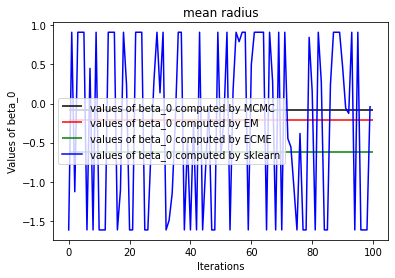

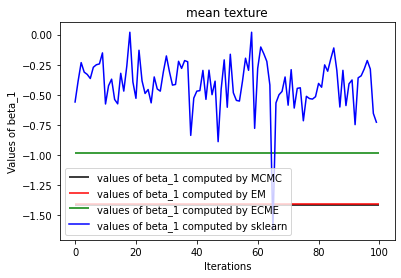

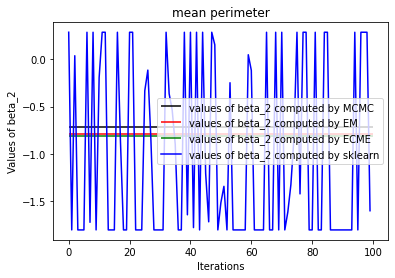

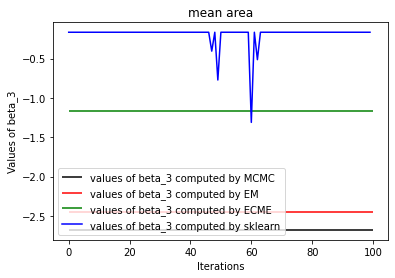

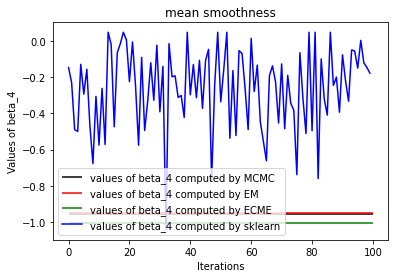

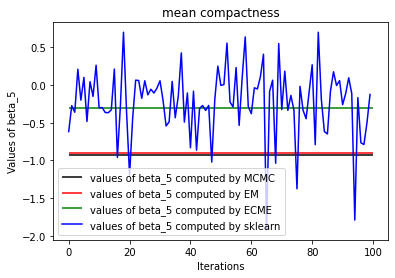

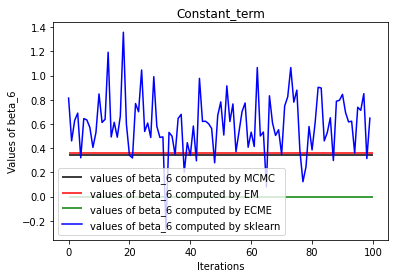

In [13]:
def comparisons_of_betas(betas, beta_EM, beta_ECME, beta_sklearn):
    n_test, k = np.shape(betas)
    x = np.arange(n_test)
    for i in range(k):
        beta_EM_i, beta_ECME_i, beta_sklearn_i = beta_EM[i], beta_ECME[i], beta_sklearn[i]
        plt.hlines(y = beta_EM_i, xmin = 0, xmax = n_test, color = 'black')
        plt.hlines(y = beta_ECME_i, xmin = 0, xmax = n_test, color = 'red')
        plt.hlines(y = beta_sklearn_i, xmin = 0, xmax = n_test, color = 'green')
        min_scale = min(beta_EM_i, beta_ECME_i, beta_sklearn_i)-1
        max_scale = max(beta_EM_i, beta_ECME_i, beta_sklearn_i)+1
        y = np.array([max(min_scale,min(betas[l][i],max_scale)) for l in range(n_test)])
        plt.plot(x, y, color = 'blue')
        plt.xlabel('Iterations')
        plt.ylabel('Values of beta_'+str(i))
        plt.legend(['values of beta_'+str(i)+' computed by MCMC', 'values of beta_'+ 
                    str(i) +' computed by EM', 'values of beta_'+ str(i) +
                    ' computed by ECME',  'values of beta_'+ str(i) +
                    ' computed by sklearn'])
        if i != (k-1):
          plt.title(features_names[i])
        else: 
          plt.title('Constant_term')
        plt.show()

comparisons_of_betas(betas, beta_EM, beta_ECME, beta_sklearn)

Now we will code spike and slab method.
The idea is to control he number of non zero coefficients of beta.
All the formulas are in the document.

These to function let us keep for a vector and matrix 

In [14]:
def vector_gamma(vector, gamma):
    vector_gamma = []
    for i in range(len(gamma)):
        if gamma[i] == 1:
            vector_gamma.append(vector[i])
    return np.array(vector_gamma)

def matrix_gamma(matrix, gamma):
    n_line, n_column = np.shape(matrix)
    construction_matrix = []
    if n_line == n_column:
        for l in range(n_line):
            line = []
            for c in range(n_column):
                if gamma[l]*gamma[c] != 0:
                    line.append(matrix[l][c])
            if line != []:
              construction_matrix.append(line)
    else:
        for l in range(n_line):
            line = []
            for c in range(n_column):
                if gamma[c] != 0:
                    line.append(matrix[l][c])
            if line != []:
              construction_matrix.append(line)

    return np.array(construction_matrix)


These are auxiliary functions for spike and slap algorithm. Every step is detailed in the paper.

In [18]:
#Step 1
def step_one_spike_and_slab(beta, x, y):
  return step_two_mcmc_svm(beta, x, y)

#def step_two_spike_and_slab()
def posterior_distribution(x, y, nu, gamma, lambda_g, b, B, big_sigma, pi):
    n_line, n_column = np.shape(x)
    s = np.sum(gamma)
    p_gamma = (pi ** s) * (1-pi)**(n_column-s)

    B_gamma = matrix_gamma(B, gamma)
    det_B_gamma_inv = np.linalg.det(np.linalg.inv(B_gamma))

    big_sigma_gamma = matrix_gamma(big_sigma, gamma)
    inv_big_sigma_gamma = np.linalg.inv(big_sigma_gamma)
    det_big_sigma_gamma = np.linalg.det(inv_big_sigma_gamma)

    x_gamma = vector_gamma(x, gamma)
    b_gamma = vector_gamma(b, gamma)

    exp_term_i = -0.5 * np.sum(np.array([((1 + lambda_g[i] - 
                                           y[i]*np.dot(x_gamma[i].T,b))**2 
                                          / lambda_g[i]) for i 
                                         in range(s)]))
    exp_term_sigma = -0.5 * (nu **(-2)) * np.dot(b_gamma.T, 
                                                 np.dot(inv_big_sigma_gamma, 
                                                        b_gamma))

    return p_gamma * np.sqrt(det_big_sigma_gamma/det_B_gamma_inv) * 1/nu * np.exp(exp_term_i + exp_term_sigma)

def normalisation_constant(x, y, nu, gamma, lambda_g, b, B, big_sigma, pi):
    constant = 0
    n_line, n_column = np.shape(x)
    gammas = []
    cummulative_values = [0]
    for i in range(1,2**(n_column)):
        gamma = []
        bin_i = bin(i)[2:]
        len_binary_i = len(bin_i)
        for j in range(n_column - len_binary_i):
          gamma.append(0)
        for carac in bin_i:
          gamma.append(int(carac))
        constant += posterior_distribution(x, y, nu, gamma, lambda_g, b, B, big_sigma, pi)
        gammas.append(gamma)
        cummulative_values.append(cummulative_values[-1] + constant)
    
    normalised_cummulative_values = np.array(cummulative_values) / np.max(cummulative_values)

    return gammas, normalised_cummulative_values

def step_two_spike_and_slab(x, y, nu, lambda_g, b, B, big_sigma, pi):
    gammas, normalised_cummulative_values = normalisation_constant(x, y, nu, gamma, lambda_g, b, B, big_sigma, pi)
    k = len(normalised_cummulative_values)
    u = random.uniform(0,1)
    indice = 0 
    while (indice < k) and (normalised_cummulative_values[indice]  < u): 
        indice += 1
    
    return (gammas[indice-1])


def step_tree_spike_and_slab(nu, big_sigma, big_omega_g, lambda_g, bold_X, gamma):
    bold_X = matrix_gamma(bold_X, gamma)
    big_lambda_g = np.diag(lambda_g)
    big_sigma = matrix_gamma(big_sigma, gamma)
    big_omega_g = matrix_gamma(big_omega_g, gamma)
    B = np.linalg.inv((nu**(-2) * np.dot(np.linalg.inv(big_sigma), 
          big_omega_g)) + np.dot(bold_X.T, np.dot(big_lambda_g, bold_X)))
    n = len(lambda_g)
    b = np.dot(B, np.dot(bold_X.T, np.ones(n) + lambda_g))
    beta = np.random.multivariate_normal(b , B)
    beta_gamma = []
    current = 0
    for i in range(len(gamma)):
      if gamma[i] == 0:
        beta_gamma.append(0)
      else:
        beta_gamma.append(beta[current])
        current+=1
    print(beta_gamma)
    return beta_gamma

Now we can compute the spike and slab algorithm.

In [19]:
def spike_and_slab_algorithm(x, y, nu = 1, pi = 0.5, n_step = 100, epsilon = 1):

    n_line, n_column = np.shape(x)
    beta = np.ones(n_column)
    previous_beta = np.array([np.inf for i in range(n_column)])
    sigma,  big_sigma, bold_X = parameters(x, y)
    step = 0
    while (epsilon < np.linalg.norm(beta - previous_beta)) and step < n_step : 
        lambda_g, big_lambda_g = step_one_spike_and_slab(beta, x, y)
        omega_g, big_omega_g = step_three_mcmc_svm(sigma, beta, nu, x, y)
        b, B = b_and_B_values(nu, big_sigma, big_omega_g, lambda_g, bold_X)
        gamma = step_two_spike_and_slab(x, y, nu, lambda_g, b, B, big_sigma, pi)
        beta = step_tree_spike_and_slab(nu, big_sigma, big_omega_g, lambda_g, bold_X, gamma)
        step += 1

    return beta


In [22]:
beta_spike_and_slab = spike_and_slab_algorithm(X_train, y_train, pi = 0.01)
y_pred_spike = np.sign(np.dot(beta_spike_and_slab,X_test.T))
precision_spike, recall_spike, f1_score_spike = scores(y_pred_spike, y_test)
print("precision_spike :",precision_spike, "recall_spike : ", recall_spike, "f1_score_spike : ", f1_score_spike)

[-6.565015716216458, 0, 6.433092604865085, 0, -0.04926612193327605, -0.924362278929685, 0.21394237879355496]
[-8.969196310814887, 0, 7.338611735918513, 0, 0.07064559539750212, -1.3197037615383465, 0]
[-0.36289372915092016, -0.5183300965965987, -0.18085420311556374, 0, 0, 0, 0]
[-0.08147483846246961, 0, -5.169114987945873, 3.0667847290121304, 0, 0, 0]
[-2.0763488628951214, -0.6412371983677323, 0.6125590639154901, 0.9212115962733571, -0.5614324842110381, 0, 0]
[-0.95410041593461, -0.42447870058390014, -0.2951661199860485, 0, -0.3172426229942381, -0.5996897860056177, 0.8560462511579175]
[-1.499737726668751, 0, -0.8029556778536386, 1.4723472544511758, -0.4580404544188602, 0, 0]
[-2.022799714196008, -0.8143026325287562, 0.49075244359103043, 0, 0, -0.7976458536434282, 0]
[0, 0, -3.012450744885088, 2.0237080202310254, 0, 0, 0]
[-1.4131595214560784, -0.7841075496663407, 0, -0.057860427331981705, -0.5080358599166469, 0, 0.689695040773302]
[0, 0, -1.9440439933924842, 1.187296494993652, 0.0032754